In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None) 

plt.figure(figsize=(14, 10))
sns.set_style("whitegrid")

colors = {
    'bg': '#EFE8E8',
    'text': '#513838',
    
    'red': '#DC3545',
    'blue': "#0A58CA",
    'cyan': '#0AA2C0',
    'green': '#1AA179',
    'purple': '#7121F3',
    'orange': '#FD7E14',
    'yellow': '#FFC107',
    'pink': '#D63384',
    'white_green': "#64B099"
}

custom_palette = [
    colors['blue'], colors['red'], colors['green'], 
    colors['orange'], colors['purple'], colors['cyan']
]

custom_params = {
    "figure.facecolor": colors['bg'],
    "axes.facecolor": colors['bg'],
    "savefig.facecolor": colors['bg'],
    
    "text.color": colors['text'],
    "axes.labelcolor": colors['text'],
    "xtick.color": colors['text'],
    "ytick.color": colors['text'],
    "font.family": "sans-serif",
    
    "axes.grid": True,
    "grid.color": colors['text'],
    "grid.alpha": 0.15,
    "grid.linestyle": "-",
    "grid.linewidth": 0.8,
    
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.edgecolor": colors['text'],
    "axes.linewidth": 0.8,
    
    "lines.linewidth": 1.5,
    "lines.markersize": 6,
}

sns.set_theme(
    context="talk",
    style="whitegrid",
    rc=custom_params,
    palette=custom_palette
)

<Figure size 1400x1000 with 0 Axes>

Таблица результатов
| Segment                    |     N |   AUC |    OR |   P-value |
|:---------------------------|------:|------:|------:|----------:|
| Возраст: Взрослые          | 10087 | 0.777 | 1.230 |     0.007 |
| Гражданство: РФ            | 18359 | 0.800 | 1.283 |     0.000 |
| Вся выборка                | 18791 | 0.805 | 1.300 |     0.000 |
| Возраст: Молодежь          |  4171 | 0.856 | 1.372 |     0.029 |
| Возраст: Сеньоры           |  2277 | 0.778 | 1.576 |     0.005 |
| Гражданство: другие страны |   432 | 0.982 | 2.623 |   nan     |
| Возраст: Подростки         |  1117 | 0.934 | 2.834 |     0.065 |


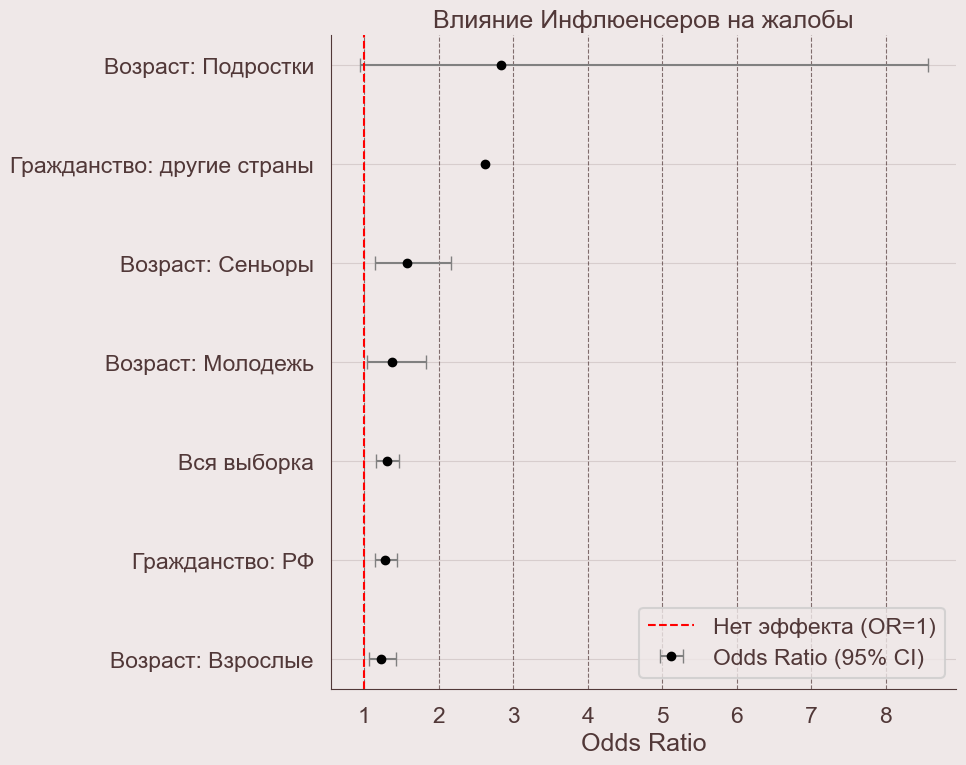

In [125]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

df = pd.read_csv('dfc.csv')
negative_reviews = df[df['review_emotion'] == 0].copy()

top_lines_99 = [
    'депозитные продукты', 'кредитные карты', 'инвестиции', 'прочие продукты',
    'автокредит', 'mobile', 'sme', 'нефинансовые продукты', 'премиальные сервисы', 'ипотека'
]
top_sources_99 = [
    'banki.ru', 'пульс', 'нет', 'otzovik', 'sravni.ru',
    'пикабу', 'вконтакте', 'суперапп', 'asn'
]

negative_reviews['age_segment'] = negative_reviews['age_segment'].fillna('Unknown')
negative_reviews['citizenship_group'] = negative_reviews['citizenship_country'].apply(
    lambda x: 'РФ' if x == 'РФ' else 'Other'
)

def get_segment_stats(subset_df, label):
    df_sub = subset_df.copy()
    df_sub['review_theme'] = df_sub['review_theme'].astype(str).str.strip()
    df_sub['target_is_tariff'] = df_sub['review_theme'].str.lower().str.contains('тарифы и условия').astype(int)

    df_sub['business_line_grouped'] = df_sub['business_line'].apply(lambda x: x if x in top_lines_99 else 'Other')
    df_sub['source_grouped'] = df_sub['review_source'].apply(lambda x: x if x in top_sources_99 else 'Other')

    df_sub['is_male'] = (df_sub['gender_cd'].fillna('Unknown') == 'M').astype(int)
    df_sub['influencer_flg'] = df_sub['influencer_flg'].fillna(0).astype(int)
    df_sub['new_flg'] = df_sub['new_flg'].fillna(0).astype(int)
    df_sub['solution_flg'] = df_sub['solution_flg'].fillna('Unknown')
    df_sub['is_mark_2'] = (df_sub['review_mark'].astype(str) == '2').astype(int)

    cat_features = ['business_line_grouped', 'source_grouped', 'solution_flg']
    num_features = ['is_male', 'influencer_flg', 'new_flg', 'is_mark_2']
    valid_num = [c for c in num_features if df_sub[c].nunique() > 1]

    model_df = df_sub[['target_is_tariff'] + cat_features + valid_num].copy()
    if model_df['target_is_tariff'].nunique() < 2:
        return None
    model_df = pd.get_dummies(model_df, columns=cat_features, drop_first=True)
    model_df = model_df.loc[:, (model_df != model_df.iloc[0]).any()]

    y = model_df['target_is_tariff']
    X = model_df.drop('target_is_tariff', axis=1)
    X = sm.add_constant(X)

    try:
        model = sm.Logit(y, X.astype(float)).fit(method='bfgs', maxiter=500, disp=0)
        y_prob = model.predict(X.astype(float))
        auc = roc_auc_score(y, y_prob)
        if 'influencer_flg' in model.params:
            coef = model.params['influencer_flg']
            or_val = np.exp(coef)
            ci = model.conf_int().loc['influencer_flg']
            or_low = np.exp(ci[0])
            or_high = np.exp(ci[1])
            pval = model.pvalues['influencer_flg']
        else:
            return None

        return {
            'Segment': label,
            'N': len(df_sub),
            'AUC': auc,
            'OR': or_val,
            'OR_low': or_low,
            'OR_high': or_high,
            'P-value': pval
        }
    except:
        return None


data = []

# Вся выборка
res = get_segment_stats(negative_reviews, "Вся выборка")
if res:
    data.append(res)

# Возрастные сегменты
for g in negative_reviews['age_segment'].unique():
    if g in ['Unknown', 'Не определен']:
        continue
    sub = negative_reviews[negative_reviews['age_segment'] == g]
    if len(sub) > 100:
        res = get_segment_stats(sub, f"Возраст: {g}")
        if res:
            data.append(res)

# Гражданство РФ
sub_rf = negative_reviews[negative_reviews['citizenship_group'] == 'РФ']
if len(sub_rf) > 100:
    res = get_segment_stats(sub_rf, "Гражданство: РФ")
    if res:
        data.append(res)

# Гражданство: другие страны (все остальные)
sub_other = negative_reviews[negative_reviews['citizenship_group'] == 'Other']
if len(sub_other) > 100:
    res = get_segment_stats(sub_other, "Гражданство: другие страны")
    if res:
        data.append(res)

results_df = pd.DataFrame(data)

plt.figure(figsize=(10, 8))
results_df = results_df.sort_values('OR', ascending=True)
errors = [results_df['OR'] - results_df['OR_low'], results_df['OR_high'] - results_df['OR']]
plt.errorbar(
    x=results_df['OR'],
    y=results_df['Segment'],
    xerr=errors,
    fmt='o',
    color='black',
    ecolor='gray',
    capsize=5,
    label='Odds Ratio (95% CI)'
)
plt.axvline(x=1, color='red', linestyle='--', label='Нет эффекта (OR=1)')
plt.title('Влияние Инфлюенсеров на жалобы')
plt.xlabel('Odds Ratio')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
print("Таблица результатов")
print(results_df[['Segment', 'N', 'AUC', 'OR', 'P-value']].to_markdown(index=False, floatfmt=".3f"))
plt.show()

In [126]:
# import pandas as pd
# import numpy as np
# import statsmodels.api as sm
# from sklearn.metrics import roc_auc_score
# import matplotlib.pyplot as plt
# import warnings
# from statsmodels.tools.sm_exceptions import HessianInversionWarning

# warnings.simplefilter('ignore', HessianInversionWarning)
# warnings.simplefilter('ignore', RuntimeWarning)

# df = pd.read_csv('dfc.csv')
# negative_reviews = df[df['review_emotion'] == 0].copy()

# top_lines_99 = [
#     'депозитные продукты', 'кредитные карты', 'инвестиции', 'прочие продукты',
#     'автокредит', 'mobile', 'sme', 'нефинансовые продукты', 'премиальные сервисы', 'ипотека'
# ]
# top_sources_99 = [
#     'banki.ru', 'пульс', 'нет', 'otzovik', 'sravni.ru',
#     'пикабу', 'вконтакте', 'суперапп', 'asn'
# ]

# negative_reviews['age_segment'] = negative_reviews['age_segment'].fillna('Unknown')
# negative_reviews['citizenship_group'] = negative_reviews['citizenship_country'].apply(
#     lambda x: 'RF' if x == 'РФ' else 'Other'
# )

# def get_segment_stats(subset_df, label):
#     df_sub = subset_df.copy()
#     df_sub['review_theme'] = df_sub['review_theme'].astype(str).str.strip()
#     df_sub['target_is_tariff'] = df_sub['review_theme'].str.lower().str.contains('тарифы и условия').astype(int)

#     df_sub['business_line_grouped'] = df_sub['business_line'].apply(lambda x: x if x in top_lines_99 else 'Other')
#     df_sub['source_grouped'] = df_sub['review_source'].apply(lambda x: x if x in top_sources_99 else 'Other')

#     df_sub['is_male'] = (df_sub['gender_cd'].fillna('Unknown') == 'M').astype(int)
#     df_sub['influencer_flg'] = df_sub['influencer_flg'].fillna(0).astype(int)
#     df_sub['new_flg'] = df_sub['new_flg'].fillna(0).astype(int)
#     df_sub['solution_flg'] = df_sub['solution_flg'].fillna('Unknown')
#     df_sub['is_mark_2'] = (df_sub['review_mark'].astype(str) == '2').astype(int)

#     cat_features = ['business_line_grouped', 'source_grouped', 'solution_flg']
#     num_features = ['is_male', 'influencer_flg', 'new_flg', 'is_mark_2']

#     if df_sub['target_is_tariff'].nunique() < 2:
#         return None
#     if df_sub['influencer_flg'].nunique() < 2:
#         return None

#     valid_num = [c for c in num_features if df_sub[c].nunique() > 1]

#     model_df = df_sub[['target_is_tariff'] + cat_features + valid_num].copy()
#     model_df = pd.get_dummies(model_df, columns=cat_features, drop_first=True)
#     model_df = model_df.loc[:, (model_df != model_df.iloc[0]).any()]

#     y = model_df['target_is_tariff']
#     X = model_df.drop('target_is_tariff', axis=1)
#     X = sm.add_constant(X)

#     try:
#         model = sm.Logit(y, X.astype(float)).fit(method='bfgs', maxiter=1000, disp=0)

#         y_prob = model.predict(X.astype(float))
#         auc = roc_auc_score(y, y_prob)

#         if 'influencer_flg' in model.params:
#             coef = model.params['influencer_flg']
#             or_val = np.exp(coef)
#             try:
#                 pval = model.pvalues['influencer_flg']
#                 ci = model.conf_int().loc['influencer_flg']
#                 or_low = np.exp(ci[0])
#                 or_high = np.exp(ci[1])
#             except:
#                 pval = np.nan
#                 or_low = or_val
#                 or_high = or_val
#         else:
#             return None

#         return {
#             'Segment': label,
#             'N': len(df_sub),
#             'AUC': auc,
#             'OR': or_val,
#             'OR_low': or_low,
#             'OR_high': or_high,
#             'P-value': pval
#         }
#     except Exception:
#         return None


# data = []
# res = get_segment_stats(negative_reviews, "GLOBAL (All)")
# if res:
#     data.append(res)

# for col in ['age_segment', 'citizenship_group']:
#     for g in negative_reviews[col].unique():
#         if col == 'age_segment' and g in ['Unknown', 'Не определен']:
#             continue
#         if col == 'citizenship_group' and g == 'Other':
#             continue

#         sub = negative_reviews[negative_reviews[col] == g]
#         if len(sub) > 100:
#             res = get_segment_stats(sub, f"{col}: {g}")
#             if res:
#                 data.append(res)

# results_df = pd.DataFrame(data)


# def get_sig(p):
#     if pd.isna(p):
#         return "N/A"
#     if p < 0.01:
#         return "***"
#     if p < 0.05:
#         return "**"
#     if p < 0.1:
#         return "*"
#     return ""


# results_df['Significance'] = results_df['P-value'].apply(get_sig)

# plt.figure(figsize=(12, 8))
# results_df = results_df.sort_values('OR', ascending=True)

# colors = []
# for _, row in results_df.iterrows():
#     if pd.isna(row['P-value']):
#         colors.append('gray')
#     elif row['P-value'] < 0.05:
#         colors.append('#D32F2F' if row['OR'] > 1 else '#388E3C')
#     else:
#         colors.append('gray')

# errors = [results_df['OR'] - results_df['OR_low'], results_df['OR_high'] - results_df['OR']]

# plt.errorbar(x=results_df['OR'], y=results_df['Segment'], xerr=errors,
#              fmt='none', ecolor='lightgray', capsize=0)
# plt.scatter(x=results_df['OR'], y=results_df['Segment'], c=colors, s=80, zorder=3)
# plt.axvline(x=1, color='black', linestyle='--', alpha=0.5)
# plt.title('Влияние Инфлюенсеров: Forest Plot', fontsize=14)
# plt.xlabel('Odds Ratio', fontsize=12)
# plt.tight_layout()
# plt.show()

# print(results_df[['Segment', 'N', 'AUC', 'OR', 'P-value', 'Significance']].to_markdown(floatfmt=".4f", index=False))

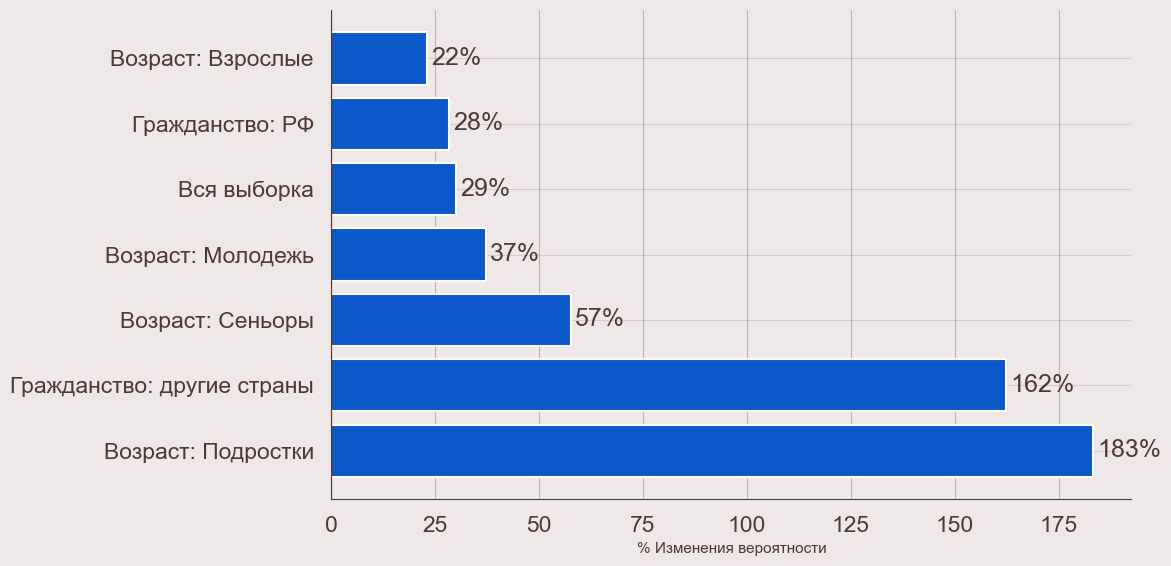


Полная таблица статистик для категорий на графике:
| Segment                    | CleanName                  |     N |   AUC |    OR |   OR_low |   OR_high |    P-value |   PercentChange |
|:---------------------------|:---------------------------|------:|------:|------:|---------:|----------:|-----------:|----------------:|
| Возраст: Подростки         | Возраст: Подростки         |  1117 | 0.934 | 2.834 |    0.938 |     8.562 |   0.064899 |           183.4 |
| Гражданство: другие страны | Гражданство: другие страны |   432 | 0.982 | 2.623 |  nan     |   nan     | nan        |           162.3 |
| Возраст: Сеньоры           | Возраст: Сеньоры           |  2277 | 0.778 | 1.576 |    1.15  |     2.159 |   0.004668 |            57.6 |
| Возраст: Молодежь          | Возраст: Молодежь          |  4171 | 0.856 | 1.372 |    1.033 |     1.822 |   0.028819 |            37.2 |
| Вся выборка                | Вся выборка                | 18791 | 0.805 | 1.3   |    1.157 |     1.46  |   1e-05    | 

In [127]:
import seaborn as sns

plt.figure(figsize=(12, 6))

viz_df = results_df.copy()
viz_df = viz_df.dropna(subset=['OR'])
viz_df['PercentChange'] = (viz_df['OR'] - 1) * 100
viz_df['Color'] = viz_df['P-value'].apply(lambda x: '#D32F2F' if x < 0.05 else 'gray')
viz_df = viz_df.sort_values('PercentChange', ascending=False)

# Очистка названий
viz_df['CleanName'] = viz_df['Segment'].str.replace('age_segment: ', '')

bars = plt.barh(viz_df['CleanName'], viz_df['PercentChange'], color=colors["blue"])

plt.axvline(0, color='black', linewidth=0.8)
# plt.title('На сколько % инфлюенсеры повышают вероятность жалобы на тарифы?', fontsize=14)
plt.xlabel('% Изменения вероятности', fontsize=11)

# Добавляем значения на бары
for bar in bars:
    width = bar.get_width()
    label_x_pos = width + 1 if width > 0 else width - 5
    plt.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{int(width)}%', va='center')

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('impact_bars.png', dpi=300)
plt.show()

# Full stats table for plotted categories (same order as on the plot)
display_cols = ['Segment', 'CleanName', 'N', 'AUC', 'OR', 'OR_low', 'OR_high', 'P-value']
if 'Significance' in viz_df.columns:
    display_cols.append('Significance')
display_cols.append('PercentChange')

print("\nПолная таблица статистик для категорий на графике:")
display_df = viz_df[display_cols].copy()
display_df['PercentChange'] = display_df['PercentChange'].round(1)
display_df['AUC'] = display_df['AUC'].round(3)
display_df['OR'] = display_df['OR'].round(3)
display_df['OR_low'] = display_df['OR_low'].round(3)
display_df['OR_high'] = display_df['OR_high'].round(3)
display_df['P-value'] = pd.to_numeric(display_df['P-value'], errors='coerce').round(6)

print(display_df.to_markdown(index=False))

In [128]:
# Print p-value for "высокодоходные с пм" segment
target_segment = results_df[results_df['Segment'].str.contains('высокодоходные с пм', case=False, na=False)]

if not target_segment.empty:
    for idx, row in target_segment.iterrows():
        print(f"Segment: {row['Segment']}")
        print(f"P-value: {row['P-value']:.6f}")
        print(f"Odds Ratio: {row['OR']:.4f}")
        print(f"95% CI: [{row['OR_low']:.4f}, {row['OR_high']:.4f}]")
        print(f"N: {row['N']}")
        print(f"Significance: {row['Significance']}")
else:
    print("Segment 'высокодоходные с пм' not found in results")

Segment 'высокодоходные с пм' not found in results


Число наблюдений после исключения Unknown: 17624

--- Результаты проверки на мультиколлинеарность (Top 10 VIF) ---
                       feature_ru       VIF
                        Константа 89.524328
               Источник: Банки.ру  8.479490
            Сегмент: Малодоходные  7.886893
                Сегмент: Доходные  7.108926
                  Источник: Пульс  5.263003
Бизнес-линия: депозитные продукты  3.874278
         Бизнес-линия: инвестиции  3.570321
              Сегмент: Защищенные  2.617773
                    Источник: Нет  2.517668
                Источник: Отзовик  2.284923

--- Результаты проверки на мультиколлинеарность (Top 10 VIF) ---
                       feature_ru       VIF
                        Константа 89.524328
               Источник: Банки.ру  8.479490
            Сегмент: Малодоходные  7.886893
                Сегмент: Доходные  7.108926
                  Источник: Пульс  5.263003
Бизнес-линия: депозитные продукты  3.874278
         Бизнес-линия: инве

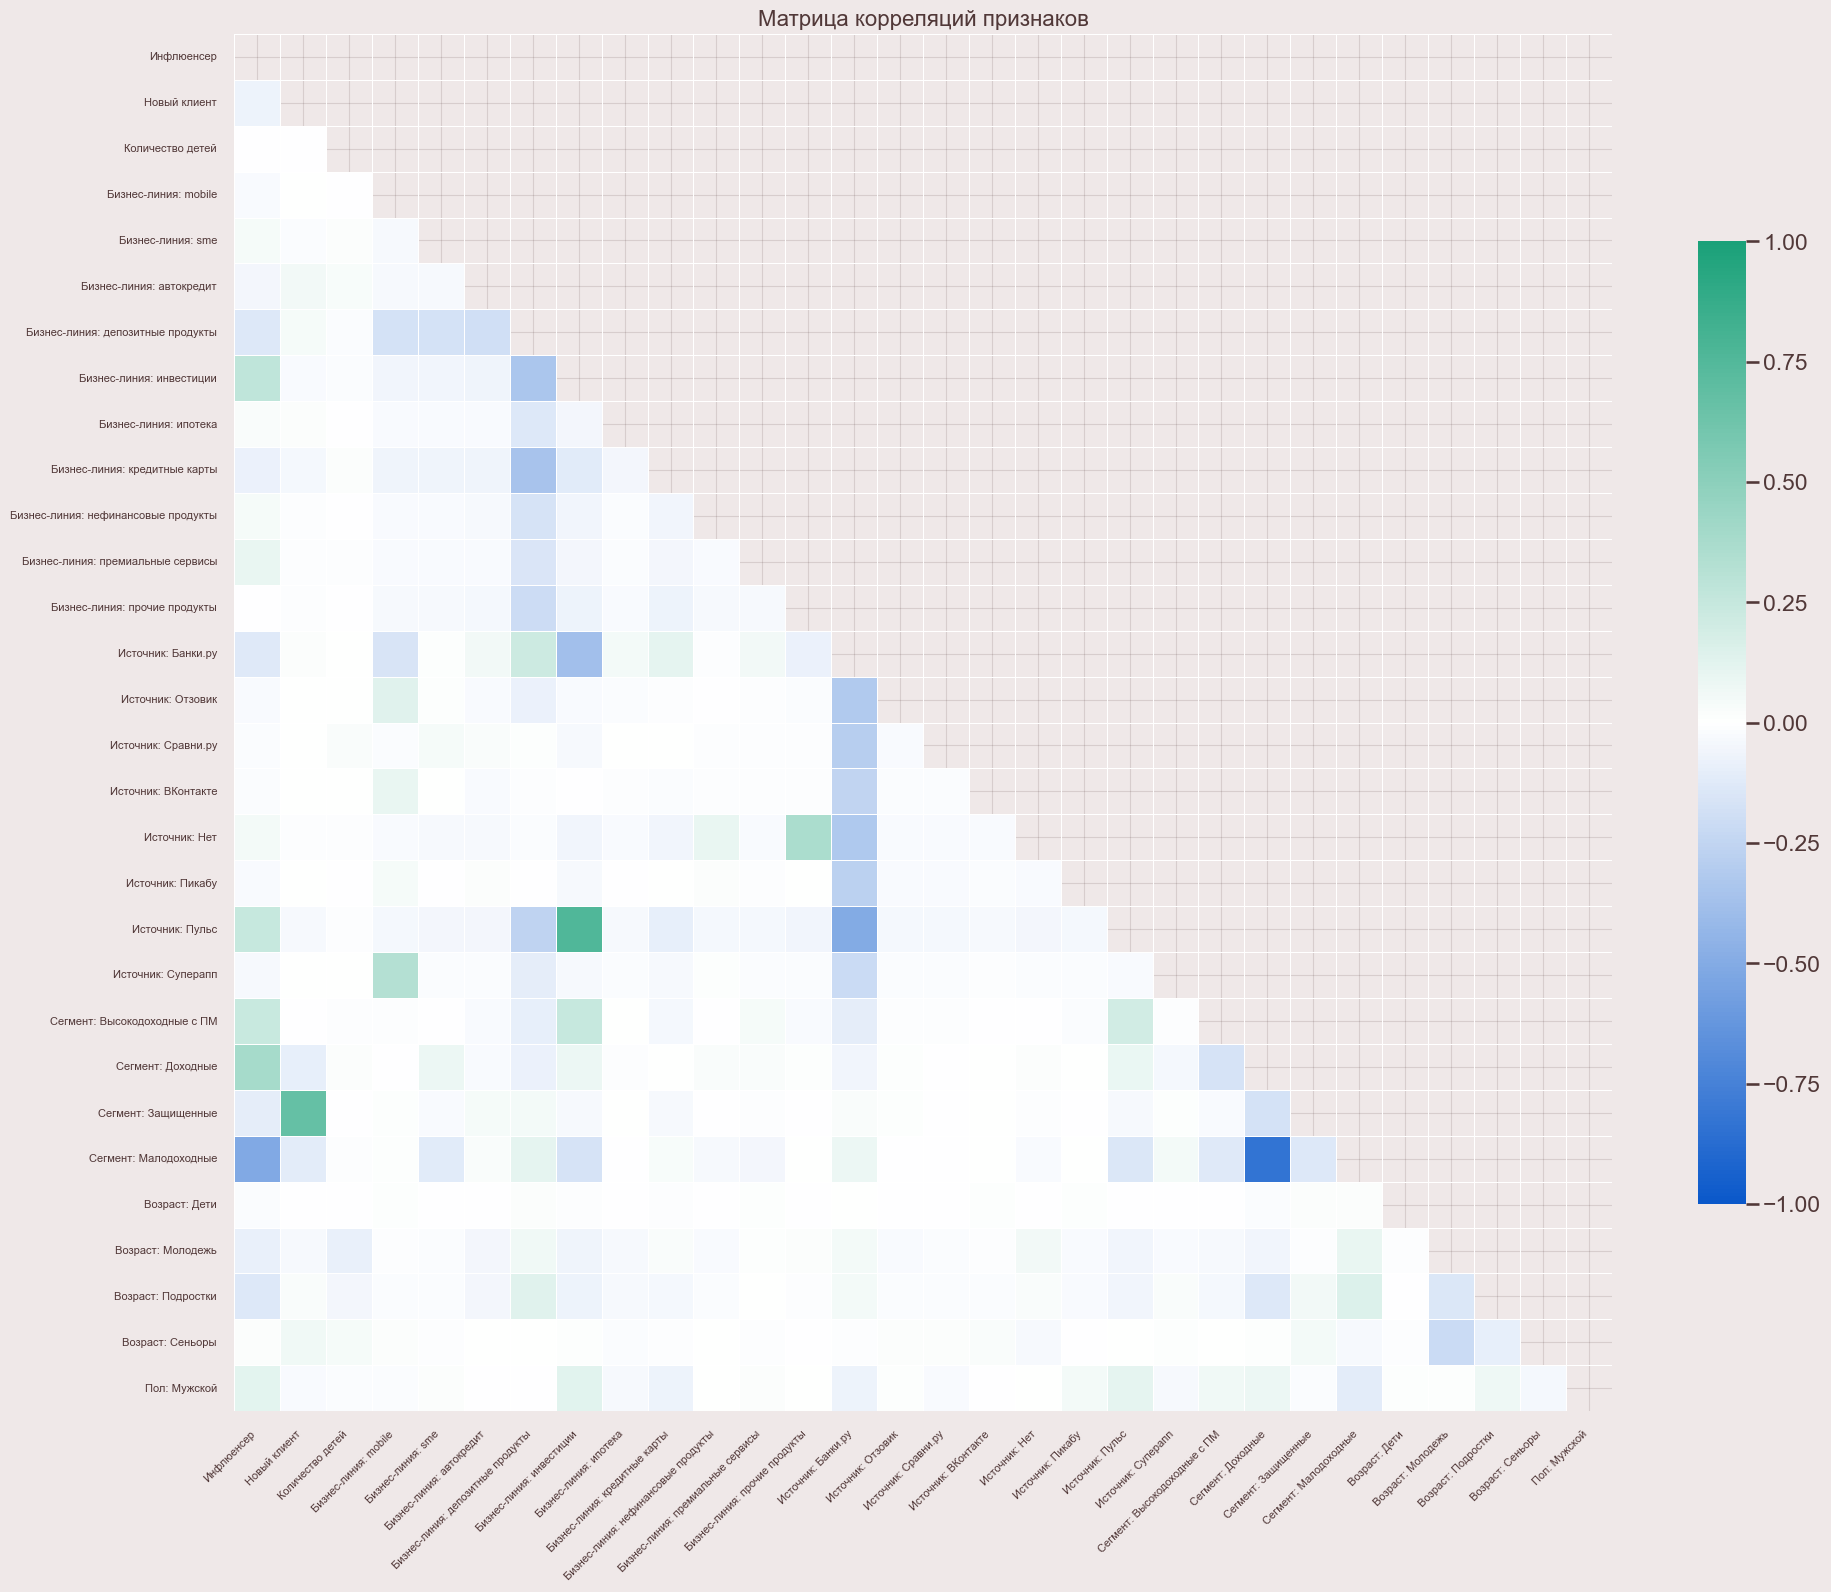

/var/folders/28/5cy4n6bn35n79ymr5smj3v7h0000gn/T/ipykernel_30617/487774364.py:159: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='VIF', y='feature_ru', data=vif_plot_data, palette=bar_colors)


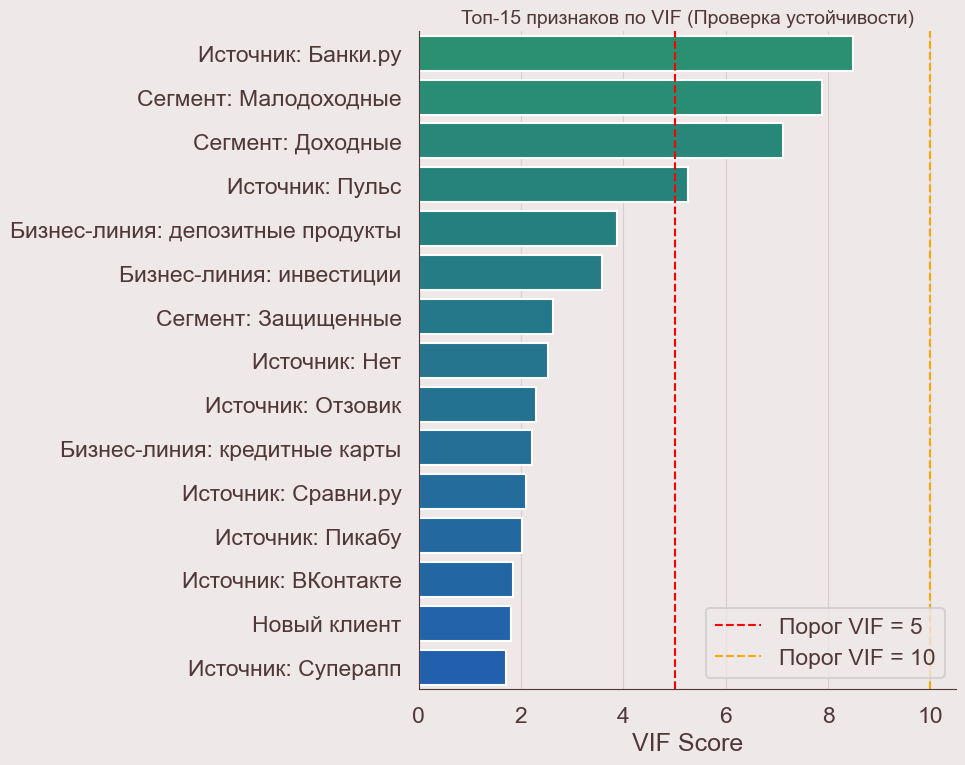

In [131]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from matplotlib.colors import LinearSegmentedColormap

# --- 1. Подготовка признаков для проверки ---
# Выбираем категориальные и числовые переменные, которые могут влиять на модель
cat_features = ['business_line', 'review_source', 'segment_name', 'age_segment', 'gender_cd']
num_features = ['influencer_flg', 'new_flg', 'children_cnt']

# Создаем копию для анализа, чтобы не менять основной датафрейм
vif_df = negative_reviews.copy()

# Заполняем пропуски базовыми значениями
for col in cat_features:
    vif_df[col] = vif_df[col].fillna('Unknown')
for col in num_features:
    vif_df[col] = vif_df[col].fillna(0)

# Группируем редкие категории (используем списки top_lines_99 и top_sources_99, если они определены выше, иначе оставляем как есть)
if 'top_lines_99' in locals():
    vif_df['business_line'] = vif_df['business_line'].apply(lambda x: x if x in top_lines_99 else 'Other')
if 'top_sources_99' in locals():
    vif_df['review_source'] = vif_df['review_source'].apply(lambda x: x if x in top_sources_99 else 'Other')

# Явно исключаем наблюдения с любыми "Unknown" / неопределёнными категориями
unknown_markers = ['Unknown', 'Не определен', 'не определен', 'NA', 'N/A']
for col in cat_features:
    vif_df = vif_df[~vif_df[col].isin(unknown_markers)]

# Если после фильтрации осталось слишком мало наблюдений, предупреждаем
print(f"Число наблюдений после исключения Unknown: {len(vif_df)}")

# OHE кодирование (One-Hot Encoding)
X_vif = pd.get_dummies(vif_df[cat_features + num_features], columns=cat_features, drop_first=True)
X_vif = X_vif.astype(float)

# Добавляем константу (необходима для корректного расчета VIF в statsmodels)
X_vif = add_constant(X_vif)

# --- 2. Расчет VIF (Variance Inflation Factor) ---
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# --- Перевод названий признаков на русский язык ---
def translate_feature_name(name):
    """Переводит техническое название признака на русский язык"""
    
    # Словарь для перевода
    translations = {
        'const': 'Константа',
        'influencer_flg': 'Инфлюенсер',
        'new_flg': 'Новый клиент',
        'children_cnt': 'Количество детей',
    }
    
    # Если точное совпадение
    if name in translations:
        return translations[name]
    
    # Переводим префиксы
    if name.startswith('business_line_'):
        category = name.replace('business_line_', '')
        return f"Бизнес-линия: {category}"
    
    if name.startswith('review_source_'):
        source = name.replace('review_source_', '')
        source_map = {
            'banki.ru': 'Банки.ру',
            'пульс': 'Пульс',
            'нет': 'Нет',
            'otzovik': 'Отзовик',
            'sravni.ru': 'Сравни.ру',
            'пикабу': 'Пикабу',
            'вконтакте': 'ВКонтакте',
            'суперапп': 'Суперапп',
            'asn': 'АСН'
        }
        return f"Источник: {source_map.get(source, source)}"
    
    if name.startswith('segment_name_'):
        segment = name.replace('segment_name_', '')
        return f"Сегмент: {segment}"
    
    if name.startswith('age_segment_'):
        age = name.replace('age_segment_', '')
        return f"Возраст: {age}"
    
    if name.startswith('gender_cd_'):
        gender = name.replace('gender_cd_', '')
        gender_map = {'M': 'Мужской', 'F': 'Женский'}
        return f"Пол: {gender_map.get(gender, gender)}"
    
    # Если не удалось перевести, возвращаем оригинал
    return name

# Применяем перевод к VIF таблице
vif_data['feature_ru'] = vif_data['feature'].apply(translate_feature_name)

# Вывод результатов текстом
print("\n--- Результаты проверки на мультиколлинеарность (Top 10 VIF) ---")
print(vif_data[['feature_ru', 'VIF']].sort_values('VIF', ascending=False).head(10).to_string(index=False))

# --- 3. Визуализация для презентации ---

# Создаем кастомную палитру: синий (-1) -> белый (0) -> зелёный (+1)
blue_white_green_cmap = LinearSegmentedColormap.from_list(
    'blue_white_green',
    [colors['blue'], '#FFFFFF', colors['green']]
)

# Кастомная палитра зелёный-синий для VIF
green_blue_cmap = LinearSegmentedColormap.from_list(
    'green_blue',
    [colors['green'], colors['blue']]
)

# А) Матрица корреляций
plt.figure(figsize=(20, 20))
# Считаем корреляцию без константы
corr_matrix = X_vif.drop(columns=['const']).corr()

# Переводим названия колонок и индексов
feature_mapping = {col: translate_feature_name(col) for col in corr_matrix.columns}
corr_matrix_ru = corr_matrix.rename(columns=feature_mapping, index=feature_mapping)

mask = np.triu(np.ones_like(corr_matrix_ru, dtype=bool))  # Скрываем верхний треугольник для чистоты
sns.heatmap(
    corr_matrix_ru,
    mask=mask,
    cmap=blue_white_green_cmap,
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .5}
)
plt.title('Матрица корреляций признаков', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig('correlation_heatmap_final.png', dpi=300)  # Сохраняем в файл
plt.show()

# Б) График VIF Scores
# Убираем константу из графика
vif_plot_data = vif_data[vif_data['feature'] != 'const'].sort_values('VIF', ascending=False).head(15)

plt.figure(figsize=(10, 8))
# Создаём градиентную палитру для барплота
n_bars = len(vif_plot_data)
bar_colors = [green_blue_cmap(i / n_bars) for i in range(n_bars)]

sns.barplot(x='VIF', y='feature_ru', data=vif_plot_data, palette=bar_colors)
plt.axvline(x=5, color='red', linestyle='--', label='Порог VIF = 5')
plt.axvline(x=10, color='orange', linestyle='--', label='Порог VIF = 10')
plt.title('Топ-15 признаков по VIF (Проверка устойчивости)', fontsize=14)
plt.xlabel('VIF Score')
plt.ylabel('')
plt.legend()
plt.tight_layout()
plt.savefig('vif_plot_final.png', dpi=300)  # Сохраняем в файл
plt.show()